# Sales-Tech Personality Classifier

This programme will classify people into Tech / Sale based on their past posts or bios on social media using the NLP classifier like BERT

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.classify import NaiveBayesClassifier

nltk.download('stopwords')
nltk.download('punkt')

### Importing the dataset

In [6]:
import random
data_set = pd.read_csv("sales_data.csv")
data_set = data_set.sample(frac=1.0)
data_set.head()
print(len(data_set))

116


### Checking the dataset for missing values

In [7]:
data_set.isnull().any()

Role    False
Bio     False
dtype: bool

## Exploring the dataset

The size of the dataset

In [8]:
data_set.shape

(116, 2)

Finding the unique vales from type of personality column

In [9]:
types = np.unique(np.array(data_set['Role']))
types

array(['Salesperson', 'Tech'], dtype=object)

The total number of posts for each type

In [10]:
total = data_set.groupby(['Role']).count()
total

,Bio
Role,
Salesperson,60
Tech,56


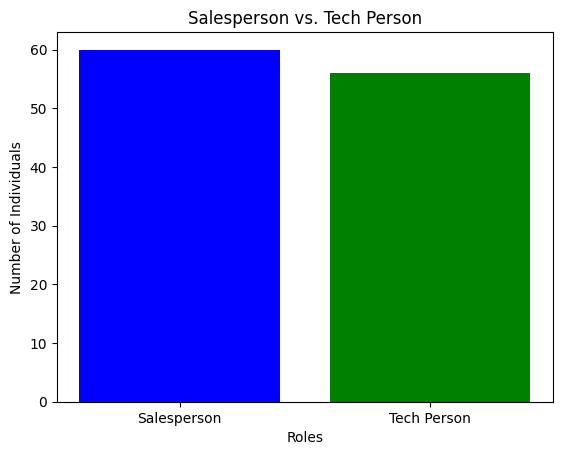

In [11]:
import matplotlib.pyplot as plt

# Sample data: Number of individuals in each role
roles = ["Salesperson", "Tech Person"]
counts = [60, 56]  # Update with your actual data

# Create a bar chart
plt.bar(roles, counts, color=['blue', 'green'])
plt.xlabel("Roles")
plt.ylabel("Number of Individuals")
plt.title("Salesperson vs. Tech Person")

# Display the chart
plt.show()

## Organising the data to create a bag words model

Segrating all the posts by their types and ***creating a new dataframe to store all this in***

In [12]:
all_posts= data_set.to_numpy()
print(all_posts)

[['Salesperson'
  "Olivia is a human resources specialist known for her talent in talent acquisition and employee development. She's passionate about diversity and inclusion in the workplace and is an active member of a local women's networking group."]
 ['Salesperson'
  'Leo is a dedicated speech therapist with a commitment to improving communication skills in individuals with speech disorders. He enjoys playing chess and volunteers as a mentor to young chess enthusiasts.']
 ['Salesperson'
  "Thomas is a dedicated team player who thrives in collaborative environments. He's known for his ability to foster teamwork and facilitate productive meetings. He's an avid reader and volunteers as a youth mentor."]
 ['Salesperson'
  "Natalie is a committed social justice advocate with a background in community organizing. She's passionate about civil rights and volunteers as a legal aid assistant for those in need."]
 ['Salesperson'
  'Mia is a creative content strategist who specializes in creat

### Creating a function to tokenize the words

In [13]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
def build_bag_of_words_features_filtered(words):
    words = nltk.word_tokenize(words)
    return {
        word:1 for word in words \
        if not word in useless_words}

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/Anush2004/nltk_data'
    - '/home/Anush2004/anaconda3/envs/newenv/nltk_data'
    - '/home/Anush2004/anaconda3/envs/newenv/share/nltk_data'
    - '/home/Anush2004/anaconda3/envs/newenv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


A random check of the function

## Creating an array of features

In [ ]:
features=[]
for i in range(0,len(all_posts)):
    features += [(build_bag_of_words_features_filtered(all_posts[i][1]), all_posts[i][0])]
print(len(features))

116


In [ ]:
print(features[0])

({'Daniel': 1, 'visionary': 1, 'game': 1, 'developer': 1, 'combining': 1, 'love': 1, 'gaming': 1, 'cutting-edge': 1, 'technology': 1, 'create': 1, 'immersive': 1, 'virtual': 1, 'experiences': 1}, 'Tech')


Data for training

In [ ]:

t= int(len(features)*0.8)
train = features[:t]
print(len(train))

92


Training the model for basic NaiveBayesClassifier

In [ ]:
sentiment_classifier = NaiveBayesClassifier.train(train)

Testing the model on the dataset it was trained for accuracy

In [ ]:
nltk.classify.util.accuracy(sentiment_classifier, train)*100

100.0

Creating the test data

In [ ]:
test = features[t:]

Testing the model on the test dataset which it has never seen before

In [ ]:
nltk.classify.util.accuracy(sentiment_classifier, test)*100

91.66666666666666

## Creating a classifyer for Tech or Sales



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data for training

In [ ]:
t= int(len(features)*0.9)
train = features[:t]
print(len(train))

104


In [ ]:
print(train[8][1])


Tech


In [ ]:
import torch

# Extract features and labels from your data
labels1=[]
features1=[]
for i in range(len(train)):
    features1.append(train[i][0]) # Replace 'your_data' with your tokenized data
    labels1.append(train[i][1])
# Tokenize and convert data to tensors
input_ids = []
attention_mask = []

for example in features1:
    # Convert the dictionary to a string representation
    example_str = ' '.join([f"{token}:{count}" for token, count in example.items()])
    
    encoded = tokenizer.encode_plus(
        example_str,
        add_special_tokens=True,
        max_length=512,  # Adjust this based on your data and model limitations
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids.append(encoded['input_ids'])
    attention_mask.append(encoded['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_mask = torch.cat(attention_mask, dim=0)


In [ ]:
label_to_id = {label: index for index, label in enumerate(set(labels1))}
print(label_to_id)
labels = [label_to_id[label] for label in labels1]
labels = torch.tensor(labels)
print(len(labels))


{'Tech': 0, 'Salesperson': 1}
104


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(input_ids, attention_mask, labels)
# Split your data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30)


In [ ]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader))

# Fine-tuning parameters
num_epochs = 3

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    # Calculate and print the average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} - Average Loss: {avg_loss:.4f}")

model.save_pretrained("latest_model")  # Save the fine-tuned model
tokenizer.save_pretrained("latest_model")

Epoch 1 - Average Loss: 0.5988
Epoch 2 - Average Loss: 0.5356
Epoch 3 - Average Loss: 0.5236


('latest_model/tokenizer_config.json',
 'latest_model/special_tokens_map.json',
 'latest_model/vocab.txt',
 'latest_model/added_tokens.json')

In [ ]:
import torch.nn.functional as F

model.eval()

total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        outputs=F.softmax(torch.tensor(outputs.logits), dim=1)
        predicted = torch.argmax(outputs, dim=1)
        total_correct += (predicted == labels).sum().item()
        total_samples += len(labels)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy * 100:.2f}%")

tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1])
Test Accuracy: 90.48%


/tmp/ipykernel_3940941/699154312.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs=F.softmax(torch.tensor(outputs.logits), dim=1)


## Cultural Fit
Now since we classified it as Tech and Sales we r doing something extra by checking the cultural fitness of a person for that company
We use similarity metric

In [ ]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
def Bag_Of_Word(words):
    words = nltk.word_tokenize(words)
    return [
        word for word in words \
        if not word in useless_words]

In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

# Define the datapoint and target corpora as lists of words
datapoint_corpus = ["Diversity", "Equity", "Inclusion", "Innovation", "Empowerment","Joy","Excelling"]

# Create spaCy Doc objects for each corpus

doc_datapoint = [nlp(word) for word in datapoint_corpus]
p_similarity=[]
for i in range(0,len(all_posts)):

    target_corpus=Bag_Of_Word(all_posts[i][1])[1:]
    doc_target = [nlp(word) for word in target_corpus]

    # Calculate the presence of matching words and assign a similarity score
    # In this example, we give a higher score if at least one word matches.
    similarity_scores = []
    for doc1 in doc_datapoint:
        max_similarity = max(doc1.similarity(doc2) for doc2 in doc_target)
        similarity_scores.append(max_similarity)

    # Calculate the overall similarity as the maximum similarity score
    overall_similarity = np.mean(similarity_scores)
    p_similarity.append(overall_similarity)
    # Print the overall similarity
    # print(f"Overall Similarity: {overall_similarity}")


p_similarity =( p_similarity -min(p_similarity)) /(max(p_similarity)-min(p_similarity)) * 10

# Define the datapoint and target corpora as lists of words
print(p_similarity)

    

[ 5.12589163  5.33464909  4.79715468  4.51086705  5.12799969  6.11969703
  6.86587619  4.60514256  7.89991095  5.44561353  6.97901126  6.84536086
  7.76115563  7.51385181  6.44480551  2.69162009  4.07900044  4.01938115
  6.63354104  4.53072949  5.00615405  6.24926589  8.29252646  6.25675794
  4.94570539  5.47868629  4.75595875  6.26949965  7.85350779  7.36864584
  2.6483483   6.18699655  7.31415233  4.22956555  4.15796139  6.329653
  5.10569057  4.32655385  6.0104022   7.93368182  3.10918694  0.
  5.1810171   5.19482423  4.99541432  5.9987015   5.05116895  3.06493401
  7.99041137  8.20515422  5.85431551  7.98917707  7.94864405  2.91068453
  7.89084546  5.65971228  3.93694759  2.74703284  2.98087057  7.05609918
  4.55051144  6.75070068  4.42628319  5.01337454  7.34523546  5.8351496
 10.          7.34480463  6.50420856  6.28140426  5.84576618  3.83088635
  4.05054163  2.93474802  7.18266436  5.31193682  3.76257666  4.51367239
  4.93824442  3.345424    3.44845062  6.35450083  1.51095297  